In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_3 = conv2DBatchNormRelu(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 3)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.maxpool2d(self.cbr_3(x))
        
        #全結合層
        x = self.sigmoid(self.fc_1(self.flatten(x)))
        x = self.fc_2(x)
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─conv2DBat

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.45it/s]


val Loss: 1.1025 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 1.3147 Acc: 0.4434


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.23it/s]


val Loss: 1.2614 Acc: 0.3395
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


train Loss: 0.9231 Acc: 0.5816


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.49it/s]


val Loss: 0.9986 Acc: 0.4295
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


train Loss: 0.8589 Acc: 0.6196


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.41it/s]


val Loss: 0.7788 Acc: 0.6476
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


train Loss: 0.8251 Acc: 0.6326


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.43it/s]


val Loss: 1.0774 Acc: 0.5481
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.8122 Acc: 0.6577


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.17it/s]


val Loss: 0.8569 Acc: 0.5843
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.10it/s]


train Loss: 0.7536 Acc: 0.6727


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.26it/s]


val Loss: 0.7267 Acc: 0.6667
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


train Loss: 0.7496 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.03it/s]


val Loss: 0.9666 Acc: 0.6024
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


train Loss: 0.6970 Acc: 0.7047


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.13it/s]


val Loss: 0.7638 Acc: 0.7100
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.6971 Acc: 0.7007


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.04it/s]


val Loss: 0.6716 Acc: 0.7238
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.6953 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.11it/s]


val Loss: 0.8930 Acc: 0.5910
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.6636 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.07it/s]


val Loss: 0.7671 Acc: 0.6895
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.6383 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.13it/s]


val Loss: 0.7945 Acc: 0.7186
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.6626 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.10it/s]


val Loss: 0.5463 Acc: 0.8057
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.6213 Acc: 0.7578


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.14it/s]


val Loss: 0.6756 Acc: 0.7210
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.5525 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.17it/s]


val Loss: 0.7432 Acc: 0.7190
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.6080 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.19it/s]


val Loss: 0.7412 Acc: 0.6929
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.5242 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.07it/s]


val Loss: 0.6684 Acc: 0.7543
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


train Loss: 0.5385 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.29it/s]


val Loss: 0.8095 Acc: 0.6595
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.07it/s]


train Loss: 0.5463 Acc: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.13it/s]


val Loss: 0.5925 Acc: 0.7833
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.5181 Acc: 0.7978


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.28it/s]


val Loss: 0.5795 Acc: 0.7862
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


train Loss: 0.5149 Acc: 0.7968


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.47it/s]


val Loss: 0.6345 Acc: 0.7700
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


train Loss: 0.5049 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.20it/s]


val Loss: 0.6074 Acc: 0.7729
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


train Loss: 0.4584 Acc: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.31it/s]


val Loss: 0.9157 Acc: 0.6752
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


train Loss: 0.4597 Acc: 0.8058


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.24it/s]


val Loss: 0.9828 Acc: 0.6576
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


train Loss: 0.5212 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.48it/s]


val Loss: 0.7079 Acc: 0.7533
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]


train Loss: 0.4228 Acc: 0.8228


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.46it/s]


val Loss: 0.6083 Acc: 0.7962
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.4955 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.13it/s]


val Loss: 0.6104 Acc: 0.7738
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


train Loss: 0.4026 Acc: 0.8348


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.50it/s]


val Loss: 0.8514 Acc: 0.7243
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


train Loss: 0.4140 Acc: 0.8428


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.56it/s]


val Loss: 0.9493 Acc: 0.7048
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


train Loss: 0.3951 Acc: 0.8288


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.58it/s]


val Loss: 1.0527 Acc: 0.6995
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


train Loss: 0.4198 Acc: 0.8308


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.33it/s]


val Loss: 0.8231 Acc: 0.7176
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.3882 Acc: 0.8468


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.16it/s]


val Loss: 0.8098 Acc: 0.7352
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.3830 Acc: 0.8448


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.42it/s]


val Loss: 0.7546 Acc: 0.7367
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


train Loss: 0.4033 Acc: 0.8428


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.52it/s]


val Loss: 0.6385 Acc: 0.7886
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


train Loss: 0.3751 Acc: 0.8498


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.48it/s]


val Loss: 0.6493 Acc: 0.7890
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


train Loss: 0.3659 Acc: 0.8549


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.44it/s]


val Loss: 0.5884 Acc: 0.8162
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


train Loss: 0.3718 Acc: 0.8498


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.28it/s]


val Loss: 0.6908 Acc: 0.7686
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


train Loss: 0.3176 Acc: 0.8759


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.52it/s]


val Loss: 0.8885 Acc: 0.7538
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.3535 Acc: 0.8679


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.26it/s]


val Loss: 0.7800 Acc: 0.7524
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.09it/s]


train Loss: 0.2995 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.39it/s]


val Loss: 0.7959 Acc: 0.7576
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


train Loss: 0.3025 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.47it/s]


val Loss: 0.8558 Acc: 0.7300
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


train Loss: 0.3600 Acc: 0.8579


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.39it/s]


val Loss: 0.7412 Acc: 0.7557
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


train Loss: 0.2912 Acc: 0.8809


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.32it/s]


val Loss: 0.7928 Acc: 0.7795
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.3253 Acc: 0.8789


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.39it/s]


val Loss: 0.9022 Acc: 0.7448
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


train Loss: 0.2923 Acc: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.30it/s]


val Loss: 0.7806 Acc: 0.7610
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


train Loss: 0.3092 Acc: 0.8759


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.41it/s]


val Loss: 0.7489 Acc: 0.7862
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


train Loss: 0.2597 Acc: 0.9009


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.13it/s]


val Loss: 1.0563 Acc: 0.7405
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


train Loss: 0.3305 Acc: 0.8609


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.12it/s]


val Loss: 0.7527 Acc: 0.7843
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


train Loss: 0.2720 Acc: 0.8959


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.17it/s]

val Loss: 0.7688 Acc: 0.7633


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

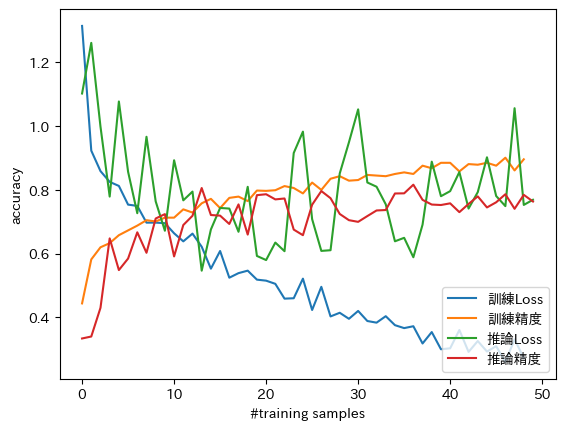

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

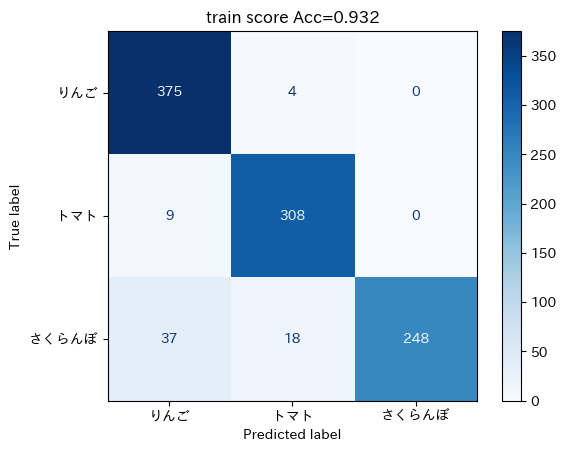

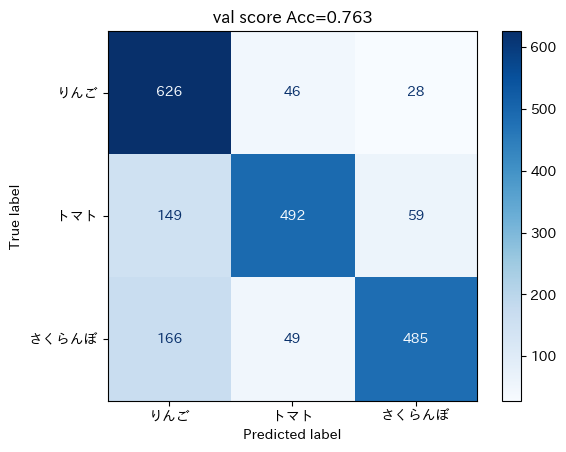

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

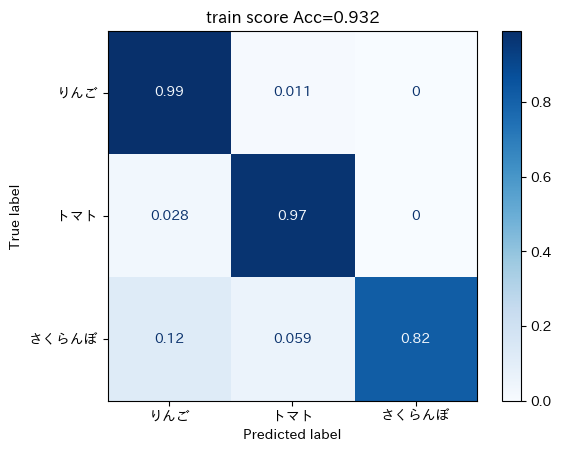

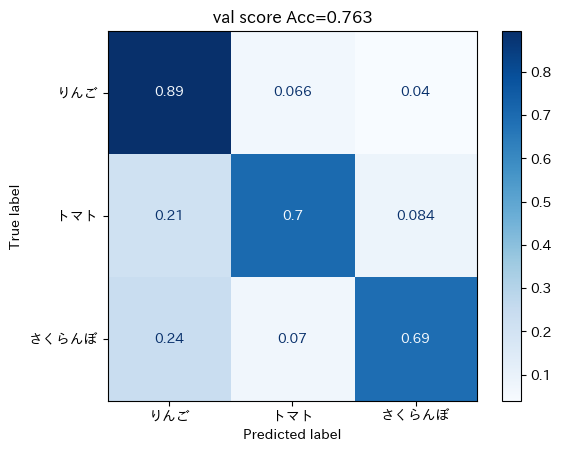

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()